<a href="https://colab.research.google.com/github/amankiitg/Foundation_AI/blob/main/Viz_DiffusionModels_finetuning_and_guidance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fine-Tuning and Guidance

In this notebook, we're going to cover two main approaches for adapting existing diffusion models:

* With **fine-tuning**, we'll re-train existing models on new data to change the type of output they produce
* With **guidance**, we'll take an existing model and steer the generation process at inference time for additional control

## What You Will Learn:

By the end of this notebook, you will know how to:

- Create a sampling loop and generate samples faster using a new scheduler
- Fine-tune an existing diffusion model on new data, including:
- Guide the sampling process with additional loss functions to add control over existing models

## Setup and Imports

To save your fine-tuned models to the Hugging Face Hub, you'll need to login with a **token that has write access**. The code below will prompt you for this and link to the relevant tokens page of your account.

In [1]:
%pip install -qq diffusers datasets accelerate wandb open-clip-torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 52.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 37.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 24.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [2]:
# Code to log in to the Hugging Face Hub, needed for sharing models
# Make sure you use a token with WRITE access
from huggingface_hub import notebook_login

notebook_login()

In [3]:
import numpy as np
import torch
import torch.nn.functional as F
import torchvision
from datasets import load_dataset
from diffusers import DDIMScheduler, DDPMPipeline
from matplotlib import pyplot as plt
from PIL import Image
from torchvision import transforms
from tqdm.auto import tqdm

In [4]:
device = (
    "mps"
    if torch.backends.mps.is_available()
    else "cuda"
    if torch.cuda.is_available()
    else "cpu"
)

## Loading A Pre-Trained Pipeline

To begin this notebook, let's load an existing pipeline and see what we can do with it:

In [5]:
image_pipe = DDPMPipeline.from_pretrained("google/ddpm-celebahq-256")
image_pipe.to(device);

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/180 [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/455M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/790 [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/256 [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

An error occurred while trying to fetch /root/.cache/huggingface/hub/models--google--ddpm-celebahq-256/snapshots/cd5c944777ea2668051904ead6cc120739b86c4d: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--google--ddpm-celebahq-256/snapshots/cd5c944777ea2668051904ead6cc120739b86c4d.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


Generating images is as simple as running the [`__call__`](https://github.com/huggingface/diffusers/blob/main/src/diffusers/pipelines/ddpm/pipeline_ddpm.py#L42) method of the pipeline by calling it like a function:

  0%|          | 0/1000 [00:00<?, ?it/s]

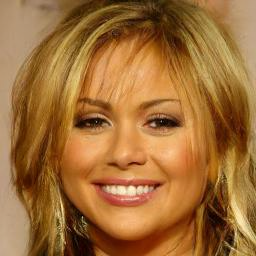

In [6]:
images = image_pipe().images
images[0]

Neat, but SLOW! So, before we get to the main topics of today, let's take a peek at the actual sampling loop and see how we can use a fancier sampler to speed this up:

## Faster Sampling with DDIM

At every step, the model is fed a noisy input and asked to predict the noise (and thus an estimate of what the fully denoised image might look like). Initially these predictions are not very good, which is why we break the process down into many steps. However, using 1000+ steps has been found to be unnecessary, and a flurry of recent research has explored how to achieve good samples with as few steps as possible.

In the 🤗 Diffusers library, these **sampling methods are handled by a scheduler**, which must perform each update via the `step()` function. To generate an image, we begin with random noise $x$. Then, for every timestep in the scheduler's noise schedule, we feed the noisy input $x$ to the model and pass the resulting prediction to the `step()` function. This returns an output with a `prev_sample` attribute - previous because we're going "backwards" in time from high noise to low noise (the opposite of the forward diffusion process).

Let's see this in action! First, we load a scheduler, here a DDIMScheduler based on the paper [Denoising Diffusion Implicit Models](https://arxiv.org/abs/2010.02502) which can give decent samples in much fewer steps than the original DDPM implementation:

In [7]:
# Create new scheduler and set num inference steps
scheduler = DDIMScheduler.from_pretrained("google/ddpm-celebahq-256")
scheduler.set_timesteps(num_inference_steps=40)

You can see that this model does 40 steps total, each jumping the equivalent of 25 steps of the original 1000-step schedule:

In [8]:
scheduler.timesteps

tensor([975, 950, 925, 900, 875, 850, 825, 800, 775, 750, 725, 700, 675, 650,
        625, 600, 575, 550, 525, 500, 475, 450, 425, 400, 375, 350, 325, 300,
        275, 250, 225, 200, 175, 150, 125, 100,  75,  50,  25,   0])

Let's create 4 random images and run through the sampling loop, viewing both the current $x$ and the predicted denoised version as the process progresses:

0it [00:00, ?it/s]

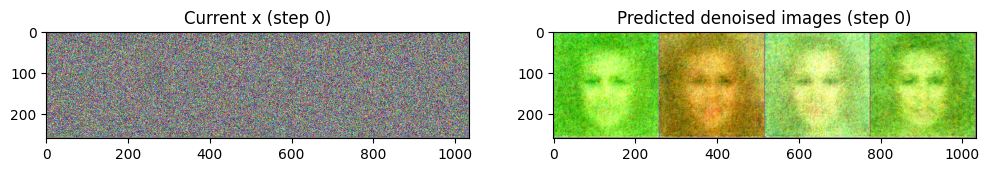

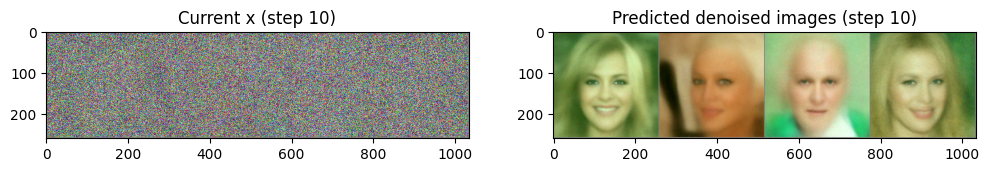

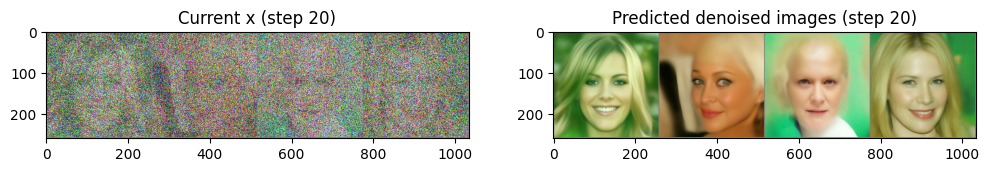

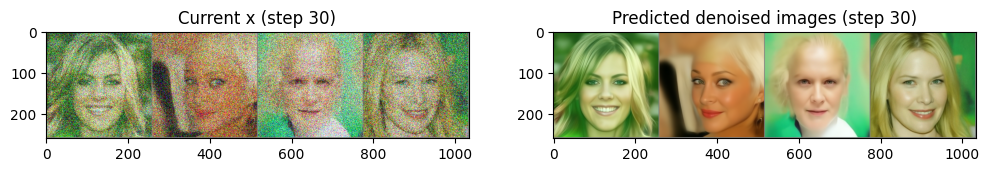

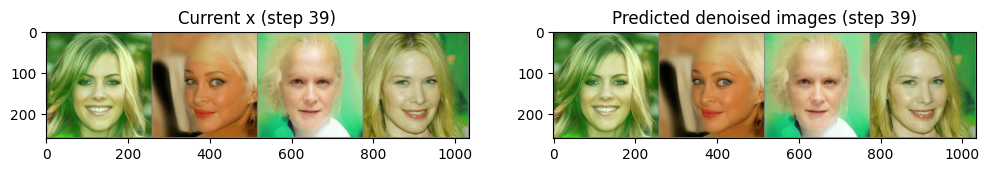

In [9]:
### RIGHT COLUMN: This shows the model’s prediction of what the final clean image x₀ would look like, if denoising stopped at this step. This is what the model thinks the clean image is, based on the current noisy image.

### LEFT COLUMN: This shows the current noisy image x_t at timestep t.It begins as pure noise (step 0), and gradually becomes more image-like. These are intermediate latents — not the final images, but the evolving noise states the model is denoising.
# The random starting point
x = torch.randn(4, 3, 256, 256).to(device)  # Batch of 4, 3-channel 256 x 256 px images

# Loop through the sampling timesteps
for i, t in tqdm(enumerate(scheduler.timesteps)):

    # Prepare model input
    model_input = scheduler.scale_model_input(x, t)

    # Get the prediction
    with torch.no_grad():
        noise_pred = image_pipe.unet(model_input, t)["sample"]

    # Calculate what the updated sample should look like with the scheduler
    scheduler_output = scheduler.step(noise_pred, t, x)

    # Update x
    x = scheduler_output.prev_sample

    # Occasionally display both x and the predicted denoised images
    if i % 10 == 0 or i == len(scheduler.timesteps) - 1:
        fig, axs = plt.subplots(1, 2, figsize=(12, 5))

        grid = torchvision.utils.make_grid(x, nrow=4).permute(1, 2, 0)
        axs[0].imshow(grid.cpu().clip(-1, 1) * 0.5 + 0.5)
        axs[0].set_title(f"Current x (step {i})")

        pred_x0 = (
            scheduler_output.pred_original_sample
        )  # Not available for all schedulers
        grid = torchvision.utils.make_grid(pred_x0, nrow=4).permute(1, 2, 0)
        axs[1].imshow(grid.cpu().clip(-1, 1) * 0.5 + 0.5)
        axs[1].set_title(f"Predicted denoised images (step {i})")
        plt.show()

As you can see, the initial predictions are not great but as the process goes on the predicted outputs get more and more refined.

You can also drop in this new scheduler in place of the original one that came with the pipeline, and sample like so:

  0%|          | 0/40 [00:00<?, ?it/s]

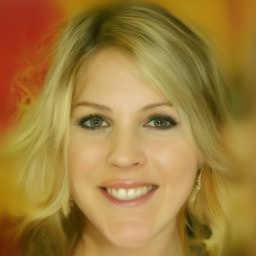

In [10]:
image_pipe.scheduler = scheduler
images = image_pipe(num_inference_steps=40).images
images[0]

Alright - we can get samples in a reasonable time now! This should speed things up as we move through the rest of this notebook :)

## Fine-Tuning

Now for the fun bit! Given this pre-trained pipeline, how might we re-train the model to generate images based on new training data?

It turns out that this looks nearly identical to training a model from scratch (as we saw in [Unit 1](https://github.com/huggingface/diffusion-models-class/tree/main/unit1)) except that we begin with the existing model. Let's see this in action and talk about a few additional considerations as we go.

First, the dataset: you could try [this vintage faces dataset](https://huggingface.co/datasets/Norod78/Vintage-Faces-FFHQAligned) or [these anime faces](https://huggingface.co/datasets/huggan/anime-faces) for something closer to the original training data of this faces model, but just for fun let's instead use the same small butterflies dataset we used to train from scratch in Unit 1. Run the code below to download the butterflies dataset and create a dataloader we can sample a batch of images from:

README.md:   0%|          | 0.00/609 [00:00<?, ?B/s]

Repo card metadata block was not found. Setting CardData to empty.


dataset_infos.json:   0%|          | 0.00/1.65k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/237M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Previewing batch:


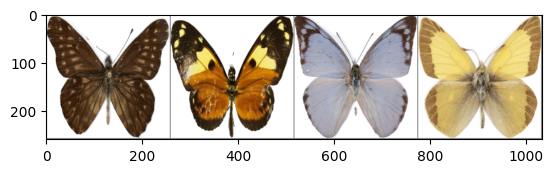

In [11]:
# @markdown load and prepare a dataset:
# Not on Colab? Comments with #@ enable UI tweaks like headings or user inputs
# but can safely be ignored if you're working on a different platform.

dataset_name = "huggan/smithsonian_butterflies_subset"  # @param
dataset = load_dataset(dataset_name, split="train")
image_size = 256  # @param
batch_size = 4  # @param
preprocess = transforms.Compose(
    [
        transforms.Resize((image_size, image_size)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
    ]
)


def transform(examples):
    images = [preprocess(image.convert("RGB")) for image in examples["image"]]
    return {"images": images}


dataset.set_transform(transform)

train_dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, shuffle=True
)

print("Previewing batch:")
batch = next(iter(train_dataloader))
grid = torchvision.utils.make_grid(batch["images"], nrow=4)
plt.imshow(grid.permute(1, 2, 0).cpu().clip(-1, 1) * 0.5 + 0.5);

**Consideration 1:** our batch size here (4) is pretty small, since we're training at large image size (256px) using a fairly large model and we'll run out of GPU RAM if we push the batch size too high. You can reduce the image size to speed things up and allow for larger batches, but these models were designed and originally trained for 256px generation.

Now for the training loop. We'll update the weights of the pre-trained model by setting the optimization target to `image_pipe.unet.parameters()`. The rest is nearly identical to the example training loop from Unit 1. This takes about 10 minutes to run on Colab, so now is a good time to grab a coffee of tea while you wait:

  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 0 average loss: 0.017750850207521582


  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 1 average loss: 0.012038789049140177


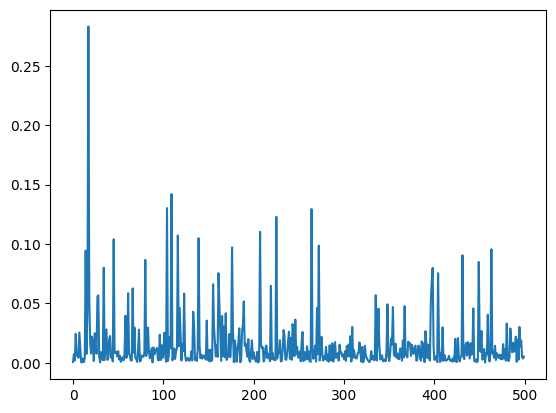

In [12]:
num_epochs = 2  # @param
lr = 1e-5  # 2param
grad_accumulation_steps = 2  # @param

optimizer = torch.optim.AdamW(image_pipe.unet.parameters(), lr=lr)

losses = []

for epoch in range(num_epochs):
    for step, batch in tqdm(enumerate(train_dataloader), total=len(train_dataloader)):
        clean_images = batch["images"].to(device)
        # Sample noise to add to the images
        noise = torch.randn(clean_images.shape).to(clean_images.device)
        bs = clean_images.shape[0]

        # Sample a random timestep for each image
        timesteps = torch.randint(
            0,
            image_pipe.scheduler.num_train_timesteps,
            (bs,),
            device=clean_images.device,
        ).long()

        # Add noise to the clean images according to the noise magnitude at each timestep
        # (this is the forward diffusion process)
        noisy_images = image_pipe.scheduler.add_noise(clean_images, noise, timesteps)

        # Get the model prediction for the noise
        noise_pred = image_pipe.unet(noisy_images, timesteps, return_dict=False)[0]

        # Compare the prediction with the actual noise:
        loss = F.mse_loss(
            noise_pred, noise
        )  # NB - trying to predict noise (eps) not (noisy_ims-clean_ims) or just (clean_ims)

        # Store for later plotting
        losses.append(loss.item())

        # Update the model parameters with the optimizer based on this loss
        loss.backward(loss)

        # Gradient accumulation:
        if (step + 1) % grad_accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()

    print(
        f"Epoch {epoch} average loss: {sum(losses[-len(train_dataloader):])/len(train_dataloader)}"
    )

# Plot the loss curve:
plt.plot(losses)

**Consideration 2:** Our loss signal is extremely noisy, since we're only working with four examples at random noise levels for each step. This is not ideal for training. One fix is to use an extremely low learning rate to limit the size of the update each step. It would be even better if we could find some way to get the same benefit we would get from using a larger batch size _without_ the memory requirements skyrocketing...

Enter [gradient accumulation](https://kozodoi.me/python/deep%20learning/pytorch/tutorial/2021/02/19/gradient-accumulation.html#:~:text=Simply%20speaking%2C%20gradient%20accumulation%20means,might%20find%20this%20tutorial%20useful.). If we call `loss.backward()` multiple times before running `optimizer.step()` and `optimizer.zero_grad()`, then PyTorch accumulates (sums) the gradients, effectively merging the signal from several batches to give a single (better) estimate which is then used to update the parameters. This results in fewer total updates being made, just like we'd see if we used a larger batch size. This is something many frameworks will handle for you (for example, [🤗 Accelerate makes this easy](https://huggingface.co/docs/accelerate/usage_guides/gradient_accumulation)) but it is nice to see it implemented from scratch since this is a useful technique for dealing with training under GPU memory constraints! As you can see from the code above (after the `# Gradient accumulation` comment) there really isn't much code needed.

Generating some images with this model, we can see that these faces are already looking mighty strange!

0it [00:00, ?it/s]

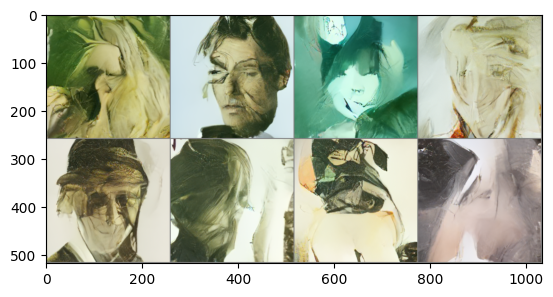

In [13]:
# @markdown Generate and plot some images:
x = torch.randn(8, 3, 256, 256).to(device)  # Batch of 8
for i, t in tqdm(enumerate(scheduler.timesteps)):
    model_input = scheduler.scale_model_input(x, t)
    with torch.no_grad():
        noise_pred = image_pipe.unet(model_input, t)["sample"]
    x = scheduler.step(noise_pred, t, x).prev_sample
grid = torchvision.utils.make_grid(x, nrow=4)
plt.imshow(grid.permute(1, 2, 0).cpu().clip(-1, 1) * 0.5 + 0.5);

**Consideration 4:** Fine-tuning can be quite unpredictable! If we trained for a lot longer, we might see some perfect butterflies. But the intermediate steps can be extremely interesting in their own right, especially if your interests are more towards the artistic side! Explore training for very short or very long periods of time, and varying the learning rate to see how this affects the kinds of output the final model produces.

### Saving and Loading Fine-Tuned Pipelines

Now that we've fine-tuned the U-Net in our diffusion model, let's save it to a local folder by running:

In [14]:
image_pipe.save_pretrained("my-finetuned-model")

As we saw in Unit 1, this will save the config, model, scheduler:

In [15]:
!ls {"my-finetuned-model"}

model_index.json  scheduler  unet


Next, you can follow the same steps outlined in Unit 1's [Introduction to Diffusers](https://github.com/huggingface/diffusion-models-class/blob/main/unit1/01_introduction_to_diffusers.ipynb) to push the model to the Hub for later use:

In [16]:
# @title Upload a locally saved pipeline to the hub

# Code to upload a pipeline saved locally to the hub
from huggingface_hub import HfApi, ModelCard, create_repo, get_full_repo_name

# Set up repo and upload files
model_name = "Vizuara-ddpm-celebahq-finetuned-butterflies-2epochs"  # @param What you want it called on the hub
local_folder_name = "my-finetuned-model"  # @param Created by the script or one you created via image_pipe.save_pretrained('save_name')
description = "Describe your model here"  # @param
hub_model_id = get_full_repo_name(model_name)
create_repo(hub_model_id)
api = HfApi()
api.upload_folder(
    folder_path=f"{local_folder_name}/scheduler", path_in_repo="", repo_id=hub_model_id
)
api.upload_folder(
    folder_path=f"{local_folder_name}/unet", path_in_repo="", repo_id=hub_model_id
)
api.upload_file(
    path_or_fileobj=f"{local_folder_name}/model_index.json",
    path_in_repo="model_index.json",
    repo_id=hub_model_id,
)

# Add a model card (optional but nice!)
content = f"""
---
license: mit
tags:
- pytorch
- diffusers
- unconditional-image-generation
- diffusion-models-class
---

# Example Fine-Tuned Model for Unit 2 of the [Diffusion Models Class 🧨](https://github.com/huggingface/diffusion-models-class)

{description}

## Usage

```python
from diffusers import DDPMPipeline

pipeline = DDPMPipeline.from_pretrained('{hub_model_id}')
image = pipeline().images[0]
image
```
"""

card = ModelCard(content)
card.push_to_hub(hub_model_id)

diffusion_pytorch_model.safetensors:   0%|          | 0.00/455M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/amankesarwani/Vizuara-ddpm-celebahq-finetuned-butterflies-2epochs/commit/33cc1b757a3dc1209c0889bff735f9da9ee4303b', commit_message='Upload README.md with huggingface_hub', commit_description='', oid='33cc1b757a3dc1209c0889bff735f9da9ee4303b', pr_url=None, repo_url=RepoUrl('https://huggingface.co/amankesarwani/Vizuara-ddpm-celebahq-finetuned-butterflies-2epochs', endpoint='https://huggingface.co', repo_type='model', repo_id='amankesarwani/Vizuara-ddpm-celebahq-finetuned-butterflies-2epochs'), pr_revision=None, pr_num=None)

Congratulations, you've now fine-tuned your first diffusion model!

For the rest of this notebook we'll use a [model](https://huggingface.co/johnowhitaker/sd-class-wikiart-from-bedrooms) I fine-tuned from [this model trained on LSUN bedrooms](https://huggingface.co/google/ddpm-bedroom-256) approximately one epoch on the [WikiArt dataset](https://huggingface.co/datasets/huggan/wikiart). If you'd prefer, you can skip this cell and use the faces/butterflies pipeline we fine-tuned in the previous section or load one from the Hub instead:

model_index.json:   0%|          | 0.00/180 [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

config.json:   0%|          | 0.00/938 [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/288 [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/455M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

An error occurred while trying to fetch /root/.cache/huggingface/hub/models--johnowhitaker--sd-class-wikiart-from-bedrooms/snapshots/85960f1e0e9d3c1eb2d8c5317a35eb5947e32e70: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--johnowhitaker--sd-class-wikiart-from-bedrooms/snapshots/85960f1e0e9d3c1eb2d8c5317a35eb5947e32e70.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


0it [00:00, ?it/s]

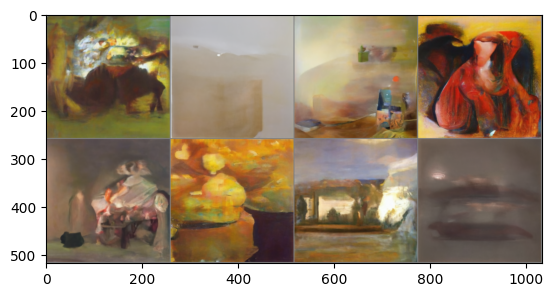

In [17]:
# Load the pretrained pipeline
pipeline_name = "johnowhitaker/sd-class-wikiart-from-bedrooms"
image_pipe = DDPMPipeline.from_pretrained(pipeline_name).to(device)

# Sample some images with a DDIM Scheduler over 40 steps
scheduler = DDIMScheduler.from_pretrained(pipeline_name)
scheduler.set_timesteps(num_inference_steps=40)

# Random starting point (batch of 8 images)
x = torch.randn(8, 3, 256, 256).to(device)

# Minimal sampling loop
for i, t in tqdm(enumerate(scheduler.timesteps)):
    model_input = scheduler.scale_model_input(x, t)
    with torch.no_grad():
        noise_pred = image_pipe.unet(model_input, t)["sample"]
    x = scheduler.step(noise_pred, t, x).prev_sample

# View the results
grid = torchvision.utils.make_grid(x, nrow=4)
plt.imshow(grid.permute(1, 2, 0).cpu().clip(-1, 1) * 0.5 + 0.5);

**Consideration 5:** It is often hard to tell how well fine-tuning is working, and what 'good performance' means may vary by use-case. For example, if you're fine-tuning a text-conditioned model like stable diffusion on a small dataset you probably want it to **retain** most of its original training so that it can understand arbitrary prompts not covered by your new dataset, while **adapting** to better match the style of your new training data. This could mean using a low learning rate alongside something like exponential model averaging, as demonstrated [in this great blog post about creating a pokemon version of stable diffusion](https://lambdalabs.com/blog/how-to-fine-tune-stable-diffusion-how-we-made-the-text-to-pokemon-model-at-lambda). In a different situation, you may want to completely re-train a model on new data (such as our bedroom -> wikiart example) in which case a larger learning rate and more training makes sense. Even though the [loss plot](https://wandb.ai/johnowhitaker/dm_finetune/runs/2upaa341) is not showing much improvement, the samples clearly show a move away from the original data and towards more 'artsy' outputs, although they remain mostly incoherent.

Which leads us to a the next section, as we examine how we might add additional guidance to such a model for better control over the outputs...

## Guidance

What do we do if we want some control over the samples generated? For example, say we wanted to bias the generated images to be a specific color. How would we go about that? Enter **guidance**, a technique for adding additional control to the sampling process.

Step one is to create our conditioning function: some measure (loss) which we'd like to minimize. Here's one for the color example, which compares the pixels of an image to a target color (by default a sort of light teal) and returns the average error:

In [18]:
def color_loss(images, target_color = (1.0, 0.75, 0.8)):
    """Given a target color (R, G, B) return a loss for how far away on average
    the images' pixels are from that color. Defaults to a light teal: (0.1, 0.9, 0.5)"""
    target = (
        torch.tensor(target_color).to(images.device) * 2 - 1
    )  # Map target color to (-1, 1)
    target = target[
        None, :, None, None
    ]  # Get shape right to work with the images (b, c, h, w)
    error = torch.abs(
        images - target
    ).mean()  # Mean absolute difference between the image pixels and the target color
    return error

Next, we'll make a modified version of the sampling loop where, at each step, we do the following:
- Create a new version of x that has requires_grad = True
- Calculate the denoised version (x0)
- Feed the predicted x0 through our loss function
- Find the **gradient** of this loss function with respect to x
- Use this conditioning gradient to modify x before we step with the scheduler, hopefully pushing x in a direction that will lead to lower loss according to our guidance function.

0it [00:00, ?it/s]

0 loss: 23.896808624267578
10 loss: 5.760097980499268
20 loss: 5.280592441558838
30 loss: 5.46174955368042


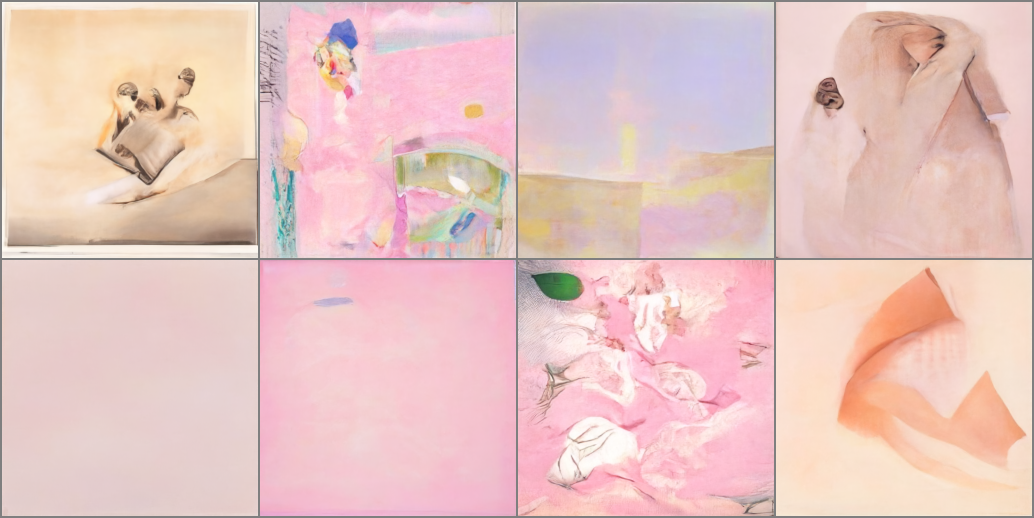

In [19]:
# The guidance scale determines the strength of the effect
guidance_loss_scale = 40  # Explore changing this to 5, or 100

x = torch.randn(8, 3, 256, 256).to(device)

for i, t in tqdm(enumerate(scheduler.timesteps)):

    # Prepare the model input
    model_input = scheduler.scale_model_input(x, t)

    # predict the noise residual
    with torch.no_grad():
        noise_pred = image_pipe.unet(model_input, t)["sample"]

    # Set x.requires_grad to True
    x = x.detach().requires_grad_()

    # Get the predicted x0
    x0 = scheduler.step(noise_pred, t, x).pred_original_sample

    # Calculate loss
    loss = color_loss(x0) * guidance_loss_scale
    if i % 10 == 0:
        print(i, "loss:", loss.item())

    # Get gradient
    cond_grad = -torch.autograd.grad(loss, x)[0]

    # Modify x based on this gradient
    x = x.detach() + cond_grad

    # Now step with scheduler
    x = scheduler.step(noise_pred, t, x).prev_sample

# View the output
grid = torchvision.utils.make_grid(x, nrow=4)
im = grid.permute(1, 2, 0).cpu().clip(-1, 1) * 0.5 + 0.5
Image.fromarray(np.array(im * 255).astype(np.uint8))

In [ ]:
# Exercise: pick your favourite colour and look up it's values in RGB space.
# Edit the `color_loss()` line in the cell above to receive these new RGB values and examine the outputs - do they match what you expect?

## CLIP Guidance

Guiding towards a color gives us a little bit of control, but what if we could just type some text describing what we want?


[CLIP](https://openai.com/blog/clip/) is a model created by OpenAI that allows us to compare images to text captions. This is extremely powerful, since it allows us to quantify how well an image matches a prompt. And since the process is differentiable, we can use this as a loss function to guide our diffusion model!

We won't go too much into the details here. The basic approach is as follows:
- Embed the text prompt to get a 512-dimensional CLIP embedding of the text
- For every step in the diffusion model process:
  - Make several variants of the predicted denoised image (having multiple variations gives a cleaner loss signal)
  - For each one, embed the image with CLIP and compare this embedding with the text embedding of the prompt (using a measure called 'Great Circle Distance Squared')
- Calculate the gradient of this loss with respect to the current noisy x and use this gradient to modify x before updating it with the scheduler.

For a deeper explanation of CLIP, check out [this lesson on the topic](https://johnowhitaker.github.io/tglcourse/clip.html) or [this report on the OpenCLIP project](https://wandb.ai/johnowhitaker/openclip-benchmarking/reports/Exploring-OpenCLIP--VmlldzoyOTIzNzIz) which we're using to load the CLIP model. Run the next cell to load a CLIP model:

In [ ]:
# @markdown load a CLIP model and define the loss function
import open_clip

clip_model, _, preprocess = open_clip.create_model_and_transforms(
    "ViT-B-32", pretrained="openai"
)
clip_model.to(device)

# Transforms to resize and augment an image + normalize to match CLIP's training data
tfms = torchvision.transforms.Compose(
    [
        torchvision.transforms.RandomResizedCrop(224),  # Random CROP each time
        torchvision.transforms.RandomAffine(
            5
        ),  # One possible random augmentation: skews the image
        torchvision.transforms.RandomHorizontalFlip(),  # You can add additional augmentations if you like
        torchvision.transforms.Normalize(
            mean=(0.48145466, 0.4578275, 0.40821073),
            std=(0.26862954, 0.26130258, 0.27577711),
        ),
    ]
)

# And define a loss function that takes an image, embeds it and compares with
# the text features of the prompt
def clip_loss(image, text_features):
    image_features = clip_model.encode_image(
        tfms(image)
    )  # Note: applies the above transforms
    input_normed = torch.nn.functional.normalize(image_features.unsqueeze(1), dim=2)
    embed_normed = torch.nn.functional.normalize(text_features.unsqueeze(0), dim=2)
    dists = (
        input_normed.sub(embed_normed).norm(dim=2).div(2).arcsin().pow(2).mul(2)
    )  # Squared Great Circle Distance
    return dists.mean()

open_clip_model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/open_clip/factory.py:388: UserWarning: These pretrained weights were trained with QuickGELU activation but the model config does not have that enabled. Consider using a model config with a "-quickgelu" suffix or enable with a flag.
  warnings.warn(


With a loss function defined, our guided sampling loop looks similar to the previous examples, replacing `color_loss()` with our new clip-based loss function:

<ipython-input-23-55226efd0391>:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast():


0it [00:00, ?it/s]

Step: 0 , Guidance loss: 7.225135326385498
Step: 25 , Guidance loss: 7.213968276977539


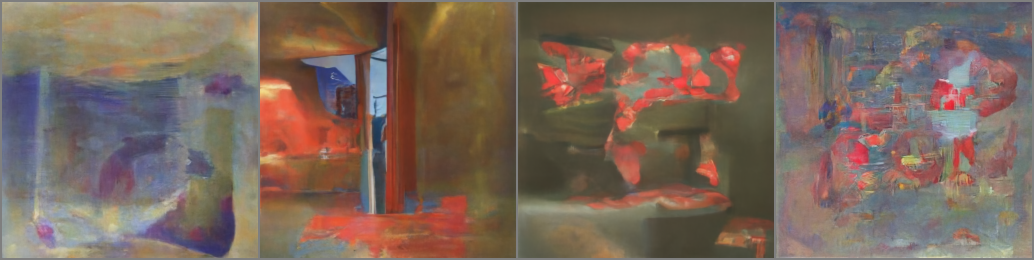

In [ ]:
# @markdown applying guidance using CLIP

prompt = "Red Rose (still life), red flower painting"  # @param

# Explore changing this
guidance_scale = 8  # @param
n_cuts = 4  # @param

# More steps -> more time for the guidance to have an effect
scheduler.set_timesteps(50)

# We embed a prompt with CLIP as our target
text = open_clip.tokenize([prompt]).to(device)
with torch.no_grad(), torch.cuda.amp.autocast():
    text_features = clip_model.encode_text(text)


x = torch.randn(4, 3, 256, 256).to(
    device
)  # RAM usage is high, you may want only 1 image at a time

for i, t in tqdm(enumerate(scheduler.timesteps)):

    model_input = scheduler.scale_model_input(x, t)

    # predict the noise residual
    with torch.no_grad():
        noise_pred = image_pipe.unet(model_input, t)["sample"]

    cond_grad = 0

    for cut in range(n_cuts):

        # Set requires grad on x
        x = x.detach().requires_grad_()

        # Get the predicted x0:
        x0 = scheduler.step(noise_pred, t, x).pred_original_sample

        # Calculate loss
        loss = clip_loss(x0, text_features) * guidance_scale

        # Get gradient (scale by n_cuts since we want the average)
        cond_grad -= torch.autograd.grad(loss, x)[0] / n_cuts

    if i % 25 == 0:
        print("Step:", i, ", Guidance loss:", loss.item())

    # Modify x based on this gradient
    alpha_bar = scheduler.alphas_cumprod[i]
    x = (
        x.detach() + cond_grad * alpha_bar.sqrt()
    )  # Note the additional scaling factor here!

    # Now step with scheduler
    x = scheduler.step(noise_pred, t, x).prev_sample


grid = torchvision.utils.make_grid(x.detach(), nrow=4)
im = grid.permute(1, 2, 0).cpu().clip(-1, 1) * 0.5 + 0.5
Image.fromarray(np.array(im * 255).astype(np.uint8))

Those look sort of like roses! It's not perfect, but if you play around with the settings you can get some pleasing images with this.

If you examine the code above you'll see I'm scaling the conditioning gradient by a factor of `alpha_bar.sqrt()`. There is some theory showing the 'right' way to scale these gradients, but in practice this is also something you can experiment with. For some types of guidance, you may want most of the effect concentrated in the early steps, for others (say, a style loss focused on textures) you may prefer that they only kick in towards the end of the generation process. Some possible schedules are shown below:

## Sharing A Custom Sampling Loop as a Gradio Demo

Perhaps you've figured out a fun loss to guide generation with, and you now want to share both your fine-tuned model and this custom sampling strategy with the world...

Enter [Gradio](https://gradio.app/). Gradio is a free and open-source tool that allows users to easily create and share interactive machine learning models through a simple web interface. With Gradio, users can build custom interfaces for their machine learning models, which can then be shared with others through a unique URL. It is also integrated into 🤗 Spaces which makes it easy to host demos and share them with others.

We'll put our core logic in a function that takes some inputs and produces an image as the output. This can then be wrapped in a simple interface that allows the user to specify some parameters (which are passed as inputs to the main generate function). There are many [components](https://gradio.app/docs/#components) available - for this example we'll use a slider for the guidance scale and a color picker to define the target color.

In [ ]:
%pip install -q gradio # Install the library

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.9/46.9 MB 22.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.2/322.2 kB 27.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.4/11.4 MB 115.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.4/62.4 kB 6.2 MB/s eta 0:00:00


In [ ]:
import gradio as gr
from PIL import Image, ImageColor
import torch
import numpy as np
import torchvision
from tqdm.notebook import tqdm
import re

device = "cuda" if torch.cuda.is_available() else "cpu"

# Placeholder: you should define `image_pipe` and `scheduler` before using
# For now, we assume they are already defined externally

# --- Helper to parse color from Gradio safely ---
def parse_color(color_str):
    if color_str.startswith("rgba"):
        # Extract r, g, b values from rgba(r, g, b, a)
        numbers = list(map(float, re.findall(r"[\d.]+", color_str)))
        r, g, b = numbers[:3]
        return [r / 255, g / 255, b / 255]
    elif color_str.startswith('#'):
        rgb = ImageColor.getcolor(color_str, "RGB")
        return [c / 255 for c in rgb]
    else:
        raise ValueError(f"Unsupported color format: {color_str}")

# --- Color loss ---
def color_loss(images, target_color=(1.0, 0.75, 0.8)):
    target = torch.tensor(target_color).to(images.device) * 2 - 1
    target = target[None, :, None, None]
    error = torch.abs(images - target).mean()
    return error

# --- Main generation function ---
def generate(color, guidance_loss_scale):
    target_color = parse_color(color)  # Get clean RGB values in [0, 1]

    x = torch.randn(1, 3, 256, 256).to(device)
    for i, t in tqdm(enumerate(scheduler.timesteps)):
        model_input = scheduler.scale_model_input(x, t)
        with torch.no_grad():
            noise_pred = image_pipe.unet(model_input, t)["sample"]

        x = x.detach().requires_grad_()
        x0 = scheduler.step(noise_pred, t, x).pred_original_sample
        loss = color_loss(x0, target_color) * guidance_loss_scale
        cond_grad = -torch.autograd.grad(loss, x)[0]
        x = x.detach() + cond_grad
        x = scheduler.step(noise_pred, t, x).prev_sample

    grid = torchvision.utils.make_grid(x, nrow=4)
    im = grid.permute(1, 2, 0).cpu().clip(-1, 1) * 0.5 + 0.5
    im = Image.fromarray(np.array(im * 255).astype(np.uint8))
    im.save("test.jpeg")
    return im

# --- Gradio UI ---
inputs = [
    gr.ColorPicker(label="Color", value="#ff55fa"),  # Pink default
    gr.Slider(label="Guidance Scale", minimum=0, maximum=30, value=3),
]
outputs = gr.Image(label="Result")

demo = gr.Interface(
    fn=generate,
    inputs=inputs,
    outputs=outputs,
    examples=[
        ["#BB2266", 3],
        ["#44CCAA", 5],
    ],
)

demo.launch(debug=True)


Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://1ea3f0c1bb475ce1c7.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://1ea3f0c1bb475ce1c7.gradio.live


## Summary and Next Steps

We've covered a lot in this notebook! Let's recap the core ideas:
- It's relatively easy to load in existing models and sample them with different schedulers
- Fine-tuning looks just like training from scratch, except that by starting from an existing model we hope to get better results more quickly
- To fine-tune large models on big images, we can use tricks like gradient accumulation to get around batch size limitations
- Logging sample images is important for fine-tuning, where a loss curve might not show much useful information
- Guidance allows us to take an unconditional model and steer the generation process based on some guidance/loss function, where at each step we find the gradient of the loss with respect to the noisy image x and update it according to this gradient before moving on to the next timestep
- Guiding with CLIP let's us control unconditional models with text!


To put this into practice, here are some specific next steps you can take:
- Fine-tune your own model and push it to the hub. This will involve picking a starting point (e.g. a model trained on [faces](https://huggingface.co/google/ddpm-celebahq-256), [bedrooms](https://huggingface.co/fusing/ddpm-lsun-bedroom), [cats](https://huggingface.co/fusing/ddpm-lsun-cat) or the [wikiart example above](https://huggingface.co/johnowhitaker/sd-class-wikiart-from-bedrooms)) and a dataset (perhaps these [animal faces](https://huggingface.co/datasets/huggan/AFHQv2) or your own images) and then running either the code in this notebook or the example script (demo usage below).
- Explore guidance using your fine-tuned model, either using one of the example guidance functions (color_loss or CLIP) or inventing your own.
- Share a demo based on this using Gradio, either modifying the [example space](https://huggingface.co/spaces/johnowhitaker/color-guided-wikiart-diffusion) to use your own model or creating your own custom version with more functionality.

We look forward to seeing your results on Discord, Twitter, and elsewhere 🤗!